Starting Bayesian optimization...

Testing configuration: depth=6, learning_rate=5e-06, loss_function=Huber, optimizer=Adadelta
Epoch 1/1 - avg_loss=0.443012, avg_acc=0.363257

Testing configuration: depth=7, learning_rate=0.005, loss_function=L1, optimizer=SGD
Epoch 1/1 - avg_loss=0.359722, avg_acc=0.740032

Testing configuration: depth=3, learning_rate=0.0005, loss_function=Huber, optimizer=Adamax
Epoch 1/1 - avg_loss=0.143328, avg_acc=0.772765

Testing configuration: depth=4, learning_rate=5e-06, loss_function=L2, optimizer=Adagrad
Epoch 1/1 - avg_loss=0.997956, avg_acc=0.406661

Testing configuration: depth=4, learning_rate=5e-07, loss_function=L1, optimizer=Adadelta
Epoch 1/1 - avg_loss=0.868393, avg_acc=0.320422

Testing configuration: depth=5, learning_rate=5e-06, loss_function=L2, optimizer=Adagrad
Epoch 1/1 - avg_loss=1.301713, avg_acc=0.252183

Testing configuration: depth=8, learning_rate=5e-05, loss_function=L2, optimizer=Adadelta
Epoch 1/1 - avg_loss=1.111450, avg_acc=0.31

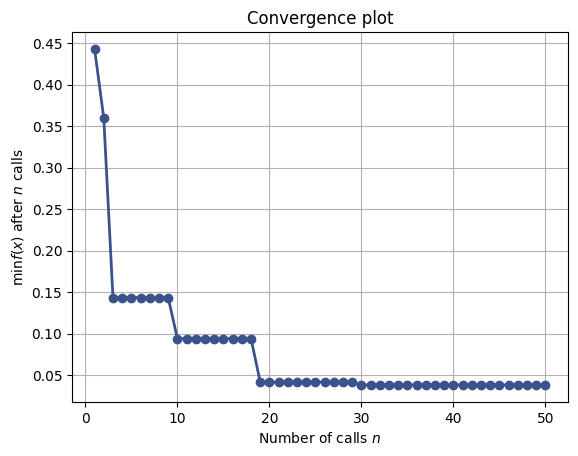


Best Depth: 4
Best Learning Rate: 0.05
Best Loss Function: Huber
Best Optimizer: SGD


In [1]:
import pennylane as qml
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle
import sys
from scipy.interpolate import UnivariateSpline
import time
from skopt import gp_minimize
from skopt.space import Real, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

dev = qml.device("default.qubit", wires=1)

prefix = "qml"
train_loader = torch.load("loaders/qml_essai_train_loader.pth")
test_loader = torch.load("loaders/qml_essai_train_loader.pth")

for x_train, y_train in train_loader:
    input_size = x_train.shape[1]
    break
    
space = [Categorical([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], name='depth'),
    Categorical([0.5, 0.05, 0.005, 0.0005, 0.00005, 0.000005, 0.0000005], name='learning_rate'),
    Categorical(['L1', 'L2', 'Huber'], name='loss_function'),
    Categorical(['SGD', 'Adam', 'RMSprop', 'Adagrad'], name='optimizer')]

def L1(yh, gt):
    return torch.abs(yh - gt)

def L2(yh, gt):
    return (yh - gt) ** 2

def Huber(yh, gt, delta=1.0):
    diff = yh - gt
    abs_diff = torch.abs(diff)
    return torch.where(abs_diff < delta, 0.5 * diff ** 2, delta * (abs_diff - 0.5 * delta))

def classif(yh):
    if yh < -0.33:
        return -1.0
    if yh > 0.33:
        return 1.0
    return 0.0

@qml.qnode(dev, interface="torch")
def gamma(params, x, depth):
    for i in range(depth):
        for j in range(input_size):
            qml.RX(params[j * 3 + i * input_size * 3], wires=0)
            qml.RY((params[j * 3 + 1 + i * input_size * 3]) * (x[0][j].item()), wires=0)
            qml.RX(params[j * 3 + 2 + i * input_size * 3], wires=0)
    return qml.expval(qml.PauliZ(0))

@use_named_args(space)
def objective(**params):
    depth = params['depth']
    learning_rate = params['learning_rate']
    loss_function = params['loss_function']
    optimizer_name = params['optimizer']
    nb_epochs = 100
    nb_params = depth * 3 * input_size
    q_params = torch.tensor((np.random.rand(nb_params) * 2 * np.pi - np.pi), requires_grad=True, dtype=torch.float64)
    print(f"Evaluating with depth={depth}, learning_rate={learning_rate}, loss_function={loss_function}, optimizer={optimizer_name}")
    if optimizer_name == 'SGD':
        opt = torch.optim.SGD([q_params], lr=learning_rate)
    elif optimizer_name == 'RMSprop':
        opt = torch.optim.RMSprop([q_params], lr=learning_rate)
    elif optimizer_name == 'Adam':
        opt = torch.optim.Adam([q_params], lr=learning_rate)
    elif optimizer_name == 'Adagrad':
        opt = torch.optim.Adagrad([q_params], lr=learning_rate)
    for epoch in range(nb_epochs):
        epoch_loss, epoch_acc = 0.0, 0
        for x_train, y_train in train_loader:
            opt.zero_grad()
            res = gamma(q_params, x_train, depth)
            if loss_function == 'L1':
                loss = L1(res, y_train)
            elif loss_function == 'L2':
                loss = L2(res, y_train)
            elif loss_function == 'Huber':
                loss = Huber(res, y_train)
            loss.backward()
            opt.step()
            epoch_loss += loss.detach().numpy()[0][0]
            if classif(res.detach().numpy()) == y_train.numpy()[0][0]:
                epoch_acc += 1
        avg_loss = epoch_loss / len(train_loader)
        avg_acc = epoch_acc / len(train_loader)
        print(f"Completed evaluation: depth={depth}, loss_function={loss_function}, test_accuracy={final_test_acc}")
    return avg_loss

res_gp = gp_minimize(objective, space, acq_func='LCB', kappa = 4.0, n_calls=50, random_state=0)

print(f"\nMeilleur score: {res_gp.fun}")
print(f"Meilleurs hyperparamètres: {res_gp.x}")

plot_convergence(res_gp)
plt.show()

best_depth = res_gp.x[0]
best_learning_rate = res_gp.x[1]
best_loss_function = res_gp.x[2]
best_optimizer = res_gp.x[3]

print(f"\nBest Depth: {best_depth}")
print(f"Best Learning Rate: {best_learning_rate}")
print(f"Best Loss Function: {best_loss_function}")
print(f"Best Optimizer: {best_optimizer}")